In [1]:
import itertools
import os
import shutil
import sqlite3
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import squarify
from matplotlib import pyplot as plt
from pandas.core.frame import DataFrame
from sklearn.preprocessing import StandardScaler
from pprint import pprint

In [3]:
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

CONFIG

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
def display_plot(plot, filename: str, prefix: str) -> None:
    plt.show()
    plt.close()

In [6]:
def load_data():
    """Load the data from the db, extract the RFM and average review attributes and returns them."""
    con = sqlite3.connect("resources/olist.db")
    con.row_factory = sqlite3.Row
    cur = con.cursor()

    res = cur.execute("""SELECT customer_id, customer_unique_id FROM customers
    where customer_id in (select customer_id from orders)""")
    customers = res.fetchall()

    res = cur.execute("select order_id, review_score from order_reviews")
    reviews = res.fetchall()

    res = cur.execute(
        """SELECT o.order_id, o.customer_id, o.order_purchase_timestamp, oi.price
    FROM orders o
    inner join order_items oi on o.order_id = oi.order_id""")
    orders = res.fetchall()

    res = cur.execute(
        "select order_id, payment_type from order_pymts where payment_type != 'not_defined'")
    payments = res.fetchall()

    cur.close()
    con.close()

    sorted_reviews = {}
    for review in reviews:
        sorted_reviews.setdefault(
            review['order_id'],
            []).append(
            review['review_score'])

    sorted_payments = {}
    for payment in payments:
        sorted_payments.setdefault(
            payment['order_id'],
            set()).add(
            payment['payment_type'])

    sorted_orders = {}
    for order in [dict(order) for order in orders]:
        order_id = order['order_id']
        order['review_score'] = sorted_reviews[order_id][0] if order['order_id'] in sorted_reviews else None

        if order_id in sorted_payments and len(sorted_payments[order_id]) > 1:
            if 'voucher' in sorted_payments[order_id]:
                sorted_payments[order_id].remove('voucher')
                payment_type = sorted_payments[order_id].pop()
                sorted_payments[order_id].add(payment_type + "_with_voucher")
            # only 1 case with debit_card + credit_card, I'm skipping it
            else:
                continue
        elif order_id not in sorted_payments:
            continue

        order['payment_type'] = sorted_payments[order_id] if order['order_id'] in sorted_payments else None
        sorted_orders.setdefault(order['customer_id'], []).append(order)

    sorted_customers = {}
    for customer in [dict(customer) for customer in customers]:
        sorted_customers.setdefault(
            customer['customer_unique_id'], []).append(
            customer['customer_id'])

    clients = []
    for customer_unique_id in sorted_customers.keys():
        customer_ids = sorted_customers[customer_unique_id]

        customer_orders = []
        for customer_id in customer_ids:
            customer_orders += sorted_orders[customer_id] if customer_id in sorted_orders else []

        if len(customer_orders) == 0:
            continue

        total_amount = sum([order['price'] for order in customer_orders])
        nb_products = len(customer_orders)

        order_timestamps = [
            datetime.strptime(
                order['order_purchase_timestamp'],
                DATE_FORMAT) for order in customer_orders]
        latest_purchase_date: datetime = max(order_timestamps)
        days_since_last_purchase = (datetime.now() - latest_purchase_date).days

        review_scores = [order['review_score']
                         for order in customer_orders if order['review_score'] is not None]
        if len(review_scores) > 0:
            average_review = sum(review_scores) / len(review_scores)
        else:
            average_review = 0

        payment_types = set(list(itertools.chain.from_iterable(
            [list(order['payment_type']) for order in customer_orders])
        ))
        if len(payment_types) == 1:
            payment_type = list(payment_types)[0]
        else:
            payment_type = "multiple"

        # Excludes 71 clients for a better visibility of the clusters
        if nb_products < 8:
            clients.append({
                'average_review': average_review,
                'recency': days_since_last_purchase,
                'frequency': nb_products,
                'monetary_value': total_amount,
                'payment_type': payment_type
            })

    return DataFrame(clients)

In [7]:
def display_rfm_stats(df: DataFrame):
    """Generate and display a table containing the RFM stats per segment."""
    RFM_stats = df.groupby("RFM_Level").agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary_value': ['mean', 'count'],
        'RFM_Score': 'mean'
    }).round(1)
    
    RFM_stats.columns = RFM_stats.columns.droplevel()
    RFM_stats.columns = [
        'Recency_Mean',
        'Frequency_Mean',
        'MonetaryValue_Mean',
        'MonetaryValue_Count',
        'RFM_Score_Mean']
    RFM_stats.sort_values("MonetaryValue_Count", ascending=False, inplace=True)
    
    pprint(RFM_stats)
    
    return RFM_stats

In [8]:
def display_rfm_segments(RFM_stats):
    """Display the RFM segments in a square plot."""
    fig = plt.gcf()
    fig.set_size_inches(16, 9)
    
    plot = squarify.plot(
        sizes=RFM_stats['MonetaryValue_Count'],
        label=[
            'Champions',
            'Loyaux',
            'Loyalistes potentiels',
            'À réactiver',
            'À risque'
        ],
        color=[
            "green",
            "orange",
            "purple",
            "maroon",
            "pink"],
        alpha=0.6)
    
    plot.set_title("RFM Segments")
    plot.set_axis_off()
    plt.show()
    plt.close()

In [9]:
def create_pieplot_for_RFM_segments(df, prefix):
    """Generate and display the pie plot for the RFM segments."""
    unique_values = df["RFM_Level"].unique()
    data = []
    labels = []
    
    for value in unique_values:
        values_count = df["RFM_Level"].value_counts()[value]
        data.append(values_count)
        labels.append(value)
        
    plt.figure(figsize=(10, 8))
    colors = sns.color_palette('pastel')[0:6]
    plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
    plt.title('RFM segments distribution')
    
    plt.show()
    plt.close()

In [10]:
def create_pieplot_for_payment_types(df, prefix):
    """Generate and display the pie plot for the payment types."""
    unique_values = df["payment_type"].unique()
    data = []
    labels = []

    for value in unique_values:
        values_count = df["payment_type"].value_counts()[value]
        data.append(values_count)
        labels.append(value)

    plt.figure(figsize=(30, 28))
    colors = sns.color_palette('pastel')[0:6]
    plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
    plt.title('Payment types')
    
    plt.show()
    plt.close()

In [11]:
def visualize_data(df, prefix):
    """Generate and display the distribution plot for all attributes."""
    create_visualization_plot_for_attribute(df, "Recency", prefix)
    create_visualization_plot_for_attribute(df, "Frequency", prefix)
    create_visualization_plot_for_attribute(df, "Monetary_Value", prefix)
    create_visualization_plot_for_attribute(df, "average_review", prefix)

    if "payment_type" in df.columns:
        create_pieplot_for_payment_types(df, prefix)
    
    if "RFM_Level" in df.columns:
        create_pieplot_for_RFM_segments(df, prefix)

In [12]:
def create_visualization_plot_for_attribute(df, attribute: str, prefix):
    """Generate and display the distribution plot for the given attribute."""
    column_name = attribute.lower().replace(" ", "_")
    
    if column_name != "rfm_score":
        plt.figure(figsize=(8, 8))
        plot = sns.displot(df[column_name])
        plot.set_xlabels(attribute.replace("average_review", "Average Review"))
        plot.set_ylabels("Count")
        display_plot(
            plot,
            f"{column_name}_distplot",
            f"visualization_{prefix}")

In [13]:
def add_rfm_columns(df):
    """Add RFM related columns to dataframe."""
    Rlabel = range(4, 0, -1)
    Mlabel = range(1, 5)
    
    df['R'] = pd.qcut(df['recency'], q=4, labels=Rlabel).values
    df['M'] = pd.qcut(df['monetary_value'], q=4, labels=Mlabel).values
    df['F'] = np.where(df['frequency'] == 1, 1, 2)
    
    df['RFM_Score'] = df[['R', 'F', 'M']].sum(axis=1)
    df['RFM_Level'] = df.apply(rfm_level, axis=1)
    return df

In [14]:
def rfm_level(df):
    """Returns the RFM level in text from the RFM score."""
    if df['RFM_Score'] >= 7:
        return 'Champions'
    elif (df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7):
        return 'Loyaux'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6):
        return 'Loyalistes potentiels'
    elif (df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5):
        return 'À réactiver'
    elif (df['RFM_Score'] >= 3) and (df['RFM_Score'] < 4):
        return 'À risque'
    else:
        return 'Perdus'

In [15]:
def visualize_rfm_segments(df):
    RFM_stats = display_rfm_stats(df)
    display_rfm_segments(RFM_stats)

Starting the exploration script.

Data loaded with 95347 customers.

Adding and visualizing the RFM attributes.

                       Recency_Mean  Frequency_Mean  MonetaryValue_Mean  \
RFM_Level                                                                 
Champions                    2307.8             1.3               225.0   
Loyaux                       2399.6             1.1               132.2   
Loyalistes potentiels        2462.2             1.1                67.5   
À réactiver                  2528.8             1.0                46.4   
À risque                     2619.3             1.0                28.6   

                       MonetaryValue_Count  RFM_Score_Mean  
RFM_Level                                                   
Champions                            38725             7.8  
Loyaux                               22342             6.0  
Loyalistes potentiels                17233             5.0  
À réactiver                          11242             4

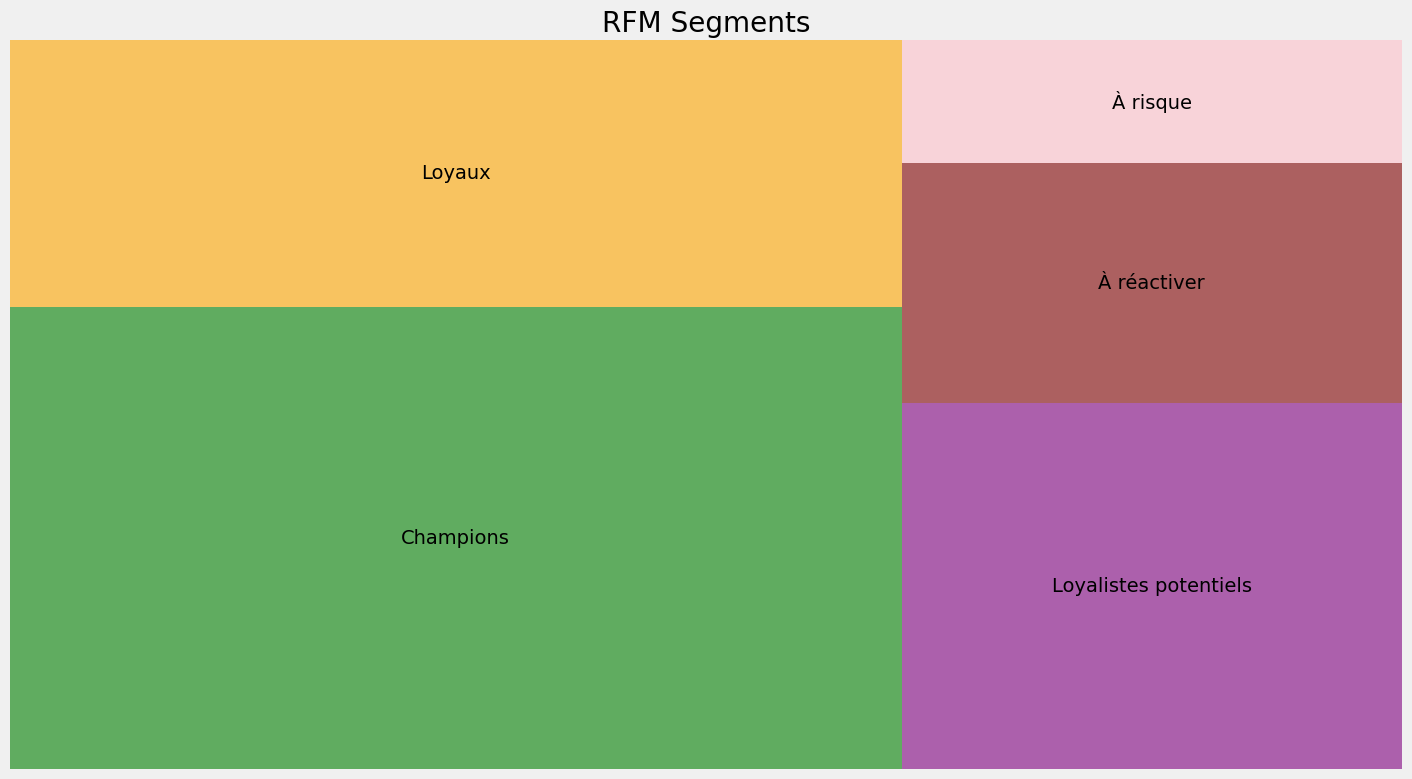

Visualizing all attributes distribution pre-scaling.



<Figure size 800x800 with 0 Axes>

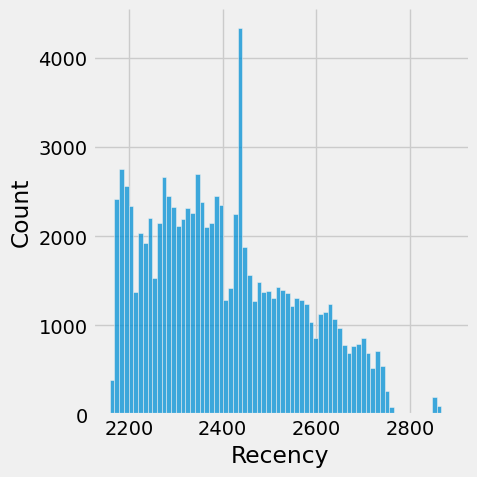

<Figure size 800x800 with 0 Axes>

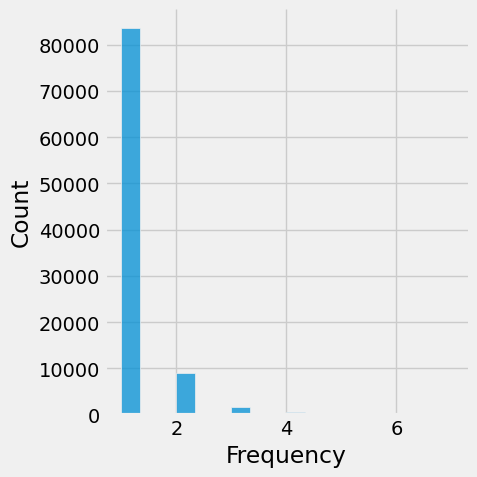

<Figure size 800x800 with 0 Axes>

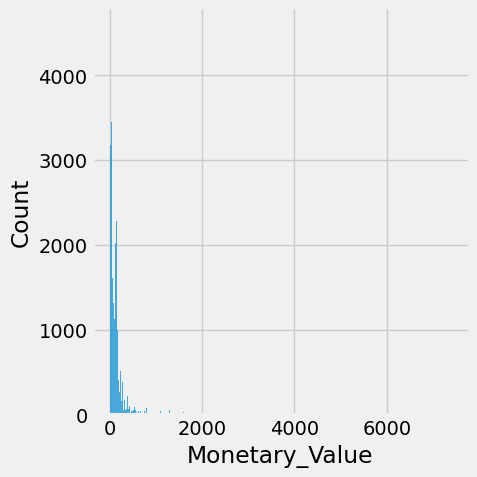

<Figure size 800x800 with 0 Axes>

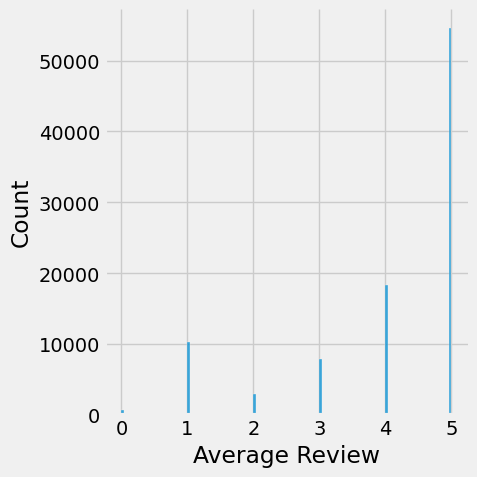

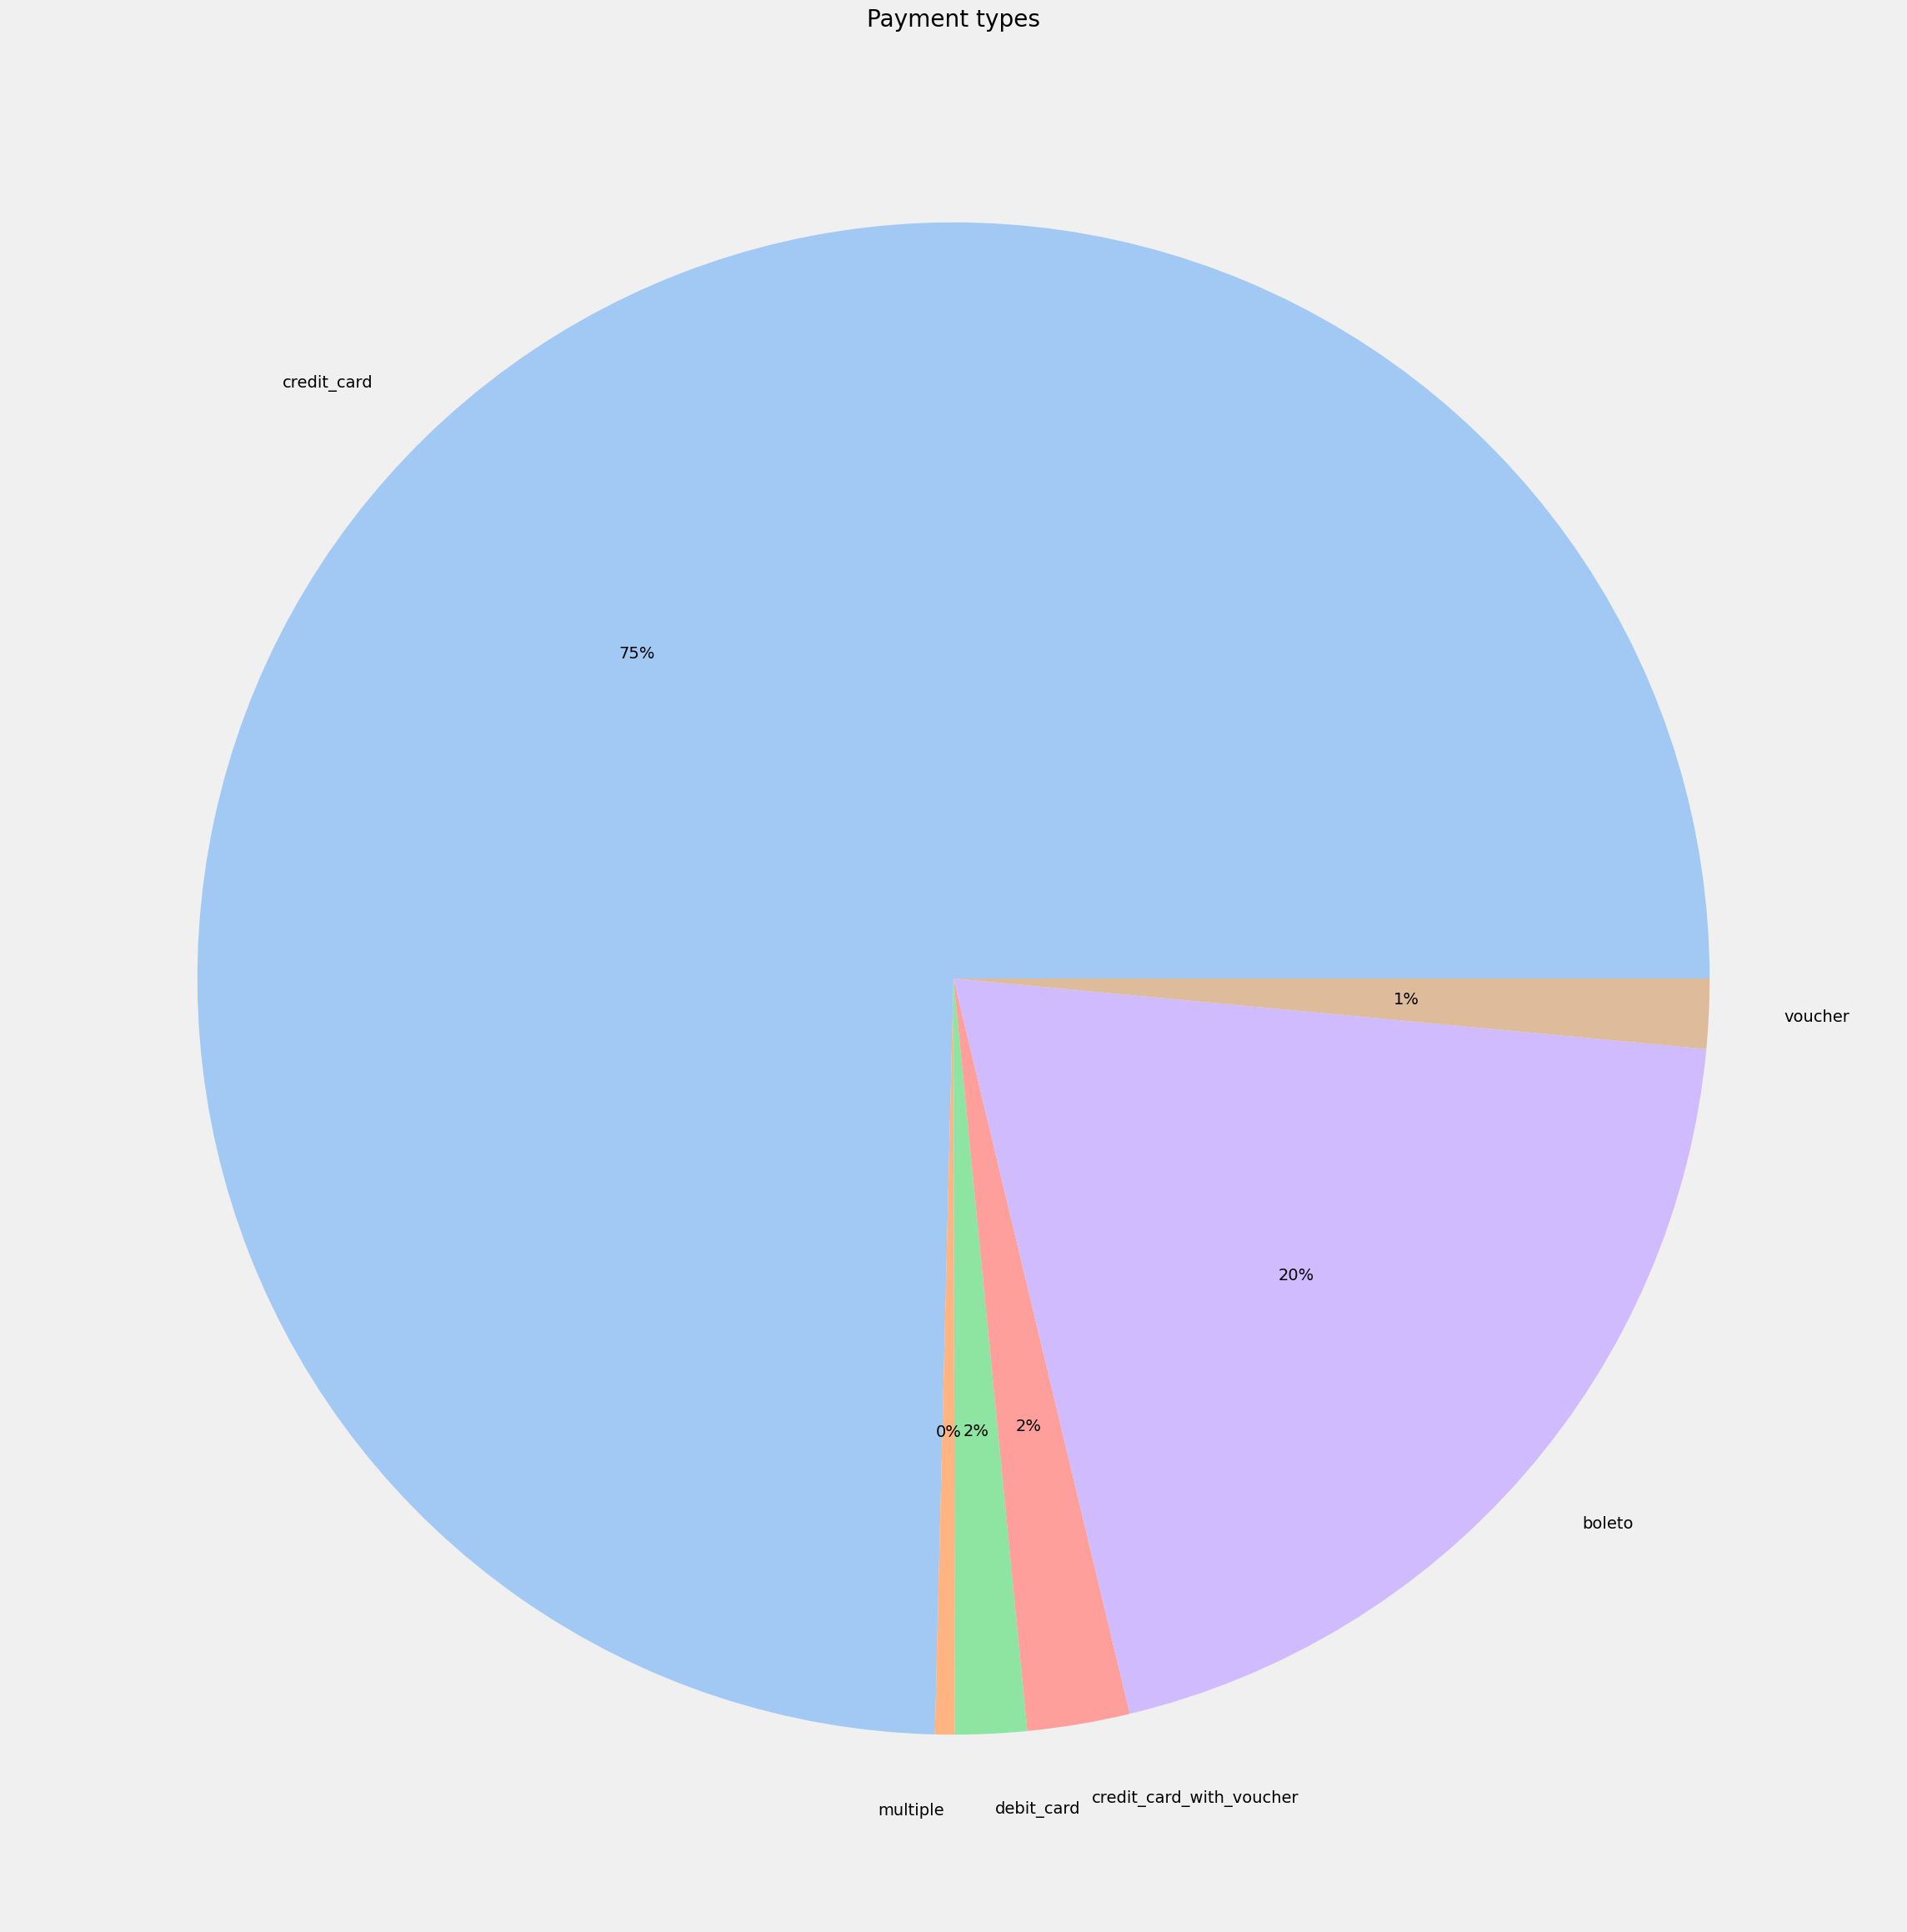

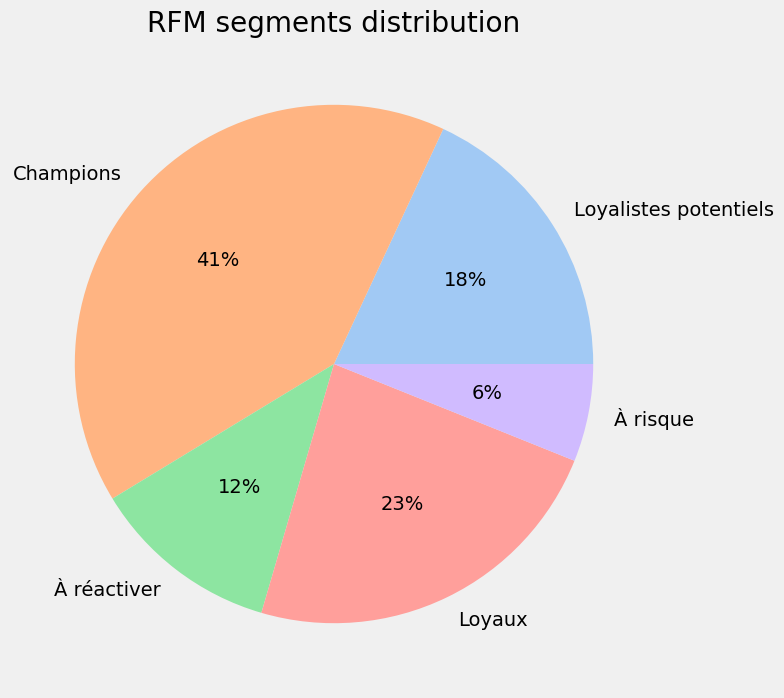

Visualizing all attributes distribution post-scaling.



<Figure size 800x800 with 0 Axes>

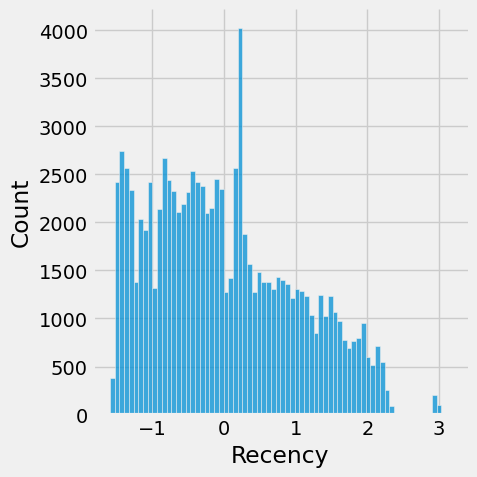

<Figure size 800x800 with 0 Axes>

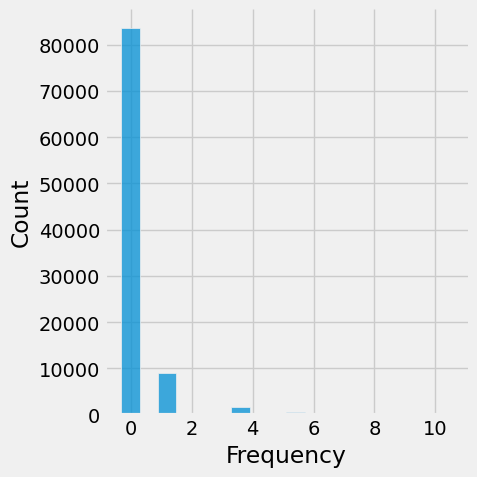

<Figure size 800x800 with 0 Axes>

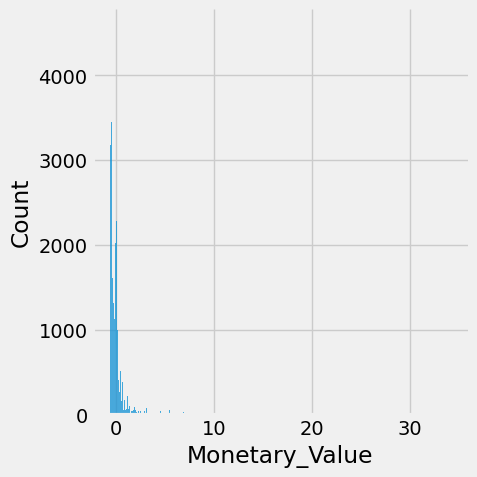

<Figure size 800x800 with 0 Axes>

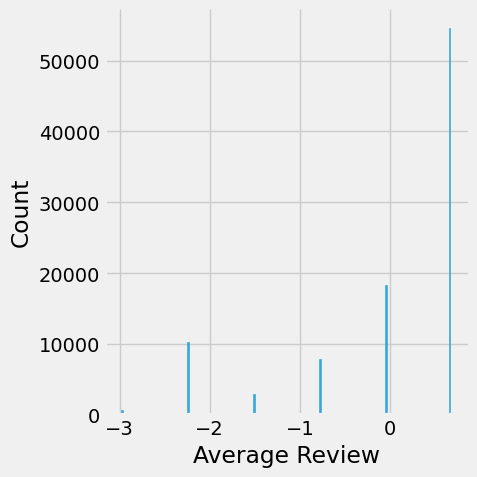

Visualization done.


In [16]:
print("Starting the exploration script.\n")

df: DataFrame = load_data()
print(f"Data loaded with {len(df)} customers.\n")

print("Adding and visualizing the RFM attributes.\n")
df = add_rfm_columns(df)
visualize_rfm_segments(df)

print("Visualizing all attributes distribution pre-scaling.\n")
visualize_data(df, "pre_scaling")

df.drop(columns=["RFM_Level"], axis=1, inplace=True)
df.drop(columns=["payment_type"], axis=1, inplace=True)

scaled_df = DataFrame(
    StandardScaler().fit_transform(df),
    columns=df.columns)
print("Visualizing all attributes distribution post-scaling.\n")
visualize_data(scaled_df, "after_scaling")

print("Visualization done.")